In [1]:
import os
import cv2

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image   



In [2]:
def cross_correlation_on_fourier_domain(input, kernel):
    input_fft = np.fft.fft2(input)
    kernel_fft = np.fft.fft2(kernel, s=input.shape)


    cross_correlation_map = input_fft * kernel_fft

    cross_correlation_map = np.fft.ifft2(cross_correlation_map).real

    return cross_correlation_map
    
def gradient(input):
    kernel_x = np.array([[-1, 0, 1]])
    kernel_y = np.array([[-1], [0], [1]])

    gradient_x = cross_correlation_on_fourier_domain(input, kernel_x)
    gradient_y = cross_correlation_on_fourier_domain(input, kernel_y)

    merged = np.sqrt(gradient_x**2 + gradient_y**2)

    return merged

def ncc(x,y):
    x_centered = x - np.mean(x)
    y_centered = y - np.mean(y)

    x_norm = np.sqrt(np.sum(x_centered**2))
    y_norm = np.sqrt(np.sum(y_centered**2))

    if x_norm == 0 or y_norm == 0:
        return 0
    
    ncc_value = np.sum(x_centered * y_centered) / (x_norm * y_norm)
    return ncc_value



def ncc_on_image(image, template):

    i_width, i_height = image.shape
    t_width, t_height = template.shape


    pad_width = t_width // 2    
    pad_height = t_height // 2

    padded_image = np.pad(image, ((pad_width, pad_width), (pad_height, pad_height)), mode='constant', constant_values=0)

    ncc_map = np.zeros((i_width, i_height))

    for i in range(i_width):
        for j in range(i_height):
            ncc_map[i, j] = ncc(padded_image[i:i+t_width, j:j+t_height], template)

    return ncc_map

def noise_generator(M,N, F1,F2, amplitude):
    noise = np.zeros((M,N))

    F1 = F1 / M
    F2 = F2 / N
    w1 = 2 * np.pi * F1
    w2 = 2 * np.pi * F2
    for i in range(M):
        for j in range(N):
            noise[i,j] = amplitude * (np.cos(w1 * i) * np.cos(w2 * j))
    return noise

def mask_radius(image, radius, value):

    w, h = image.shape

    c_x = w // 2
    c_y = h // 2

    for i in range(image.shape[0]):
        for j in range(image.shape[1]):

            if np.sqrt((i - c_x)**2 + (j - c_y)**2) < radius:
                image[i, j] = value

    return image


In [3]:
def letter_draw(letter, font_size):
    # Create initial image
    temp_size = font_size * 2
    temp_img = np.zeros((temp_size, temp_size), dtype=np.uint8)
    
    # Calculate font scale
    font_scale = font_size / 50
    thickness = max(1, int(font_size / 25))
    
    # Draw text in center of temp image
    (text_width, text_height), baseline = cv2.getTextSize(
        letter,
        cv2.FONT_HERSHEY_SIMPLEX,
        font_scale,
        thickness
    )
    
    x = (temp_size - text_width) // 2
    y = (temp_size + text_height) // 2
    
    cv2.putText(
        temp_img,
        letter,
        (x, y),
        cv2.FONT_HERSHEY_SIMPLEX,
        font_scale,
        255, 
        thickness
    )
    
    # Find letter boundaries
    rows = np.any(temp_img, axis=1)
    cols = np.any(temp_img, axis=0)
    ymin, ymax = np.where(rows)[0][[0, -1]]
    xmin, xmax = np.where(cols)[0][[0, -1]]
    
    # Crop to letter boundaries
    letter_img = temp_img[ymin-10:ymax+1+10, xmin-10:xmax+1+10]
    
    return letter_img


def plot_ncc_3d(ncc_map):
    # Create coordinate grids
    y, x = np.meshgrid(np.arange(ncc_map.shape[0]), 
                      np.arange(ncc_map.shape[1]), 
                      indexing='ij')
    
    # Create 3D plot
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')
    
    # Plot surface
    surf = ax.plot_surface(x, y, ncc_map, 
                          cmap='viridis',
                          edgecolor='none')
    
    # Customize plot
    ax.set_title('3D Normalized Cross-Correlation Map')
    ax.set_xlabel('X Position')
    ax.set_ylabel('Y Position')
    ax.set_zlabel('Correlation Value')
    
    # Add colorbar
    fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5)
    
    # Optimize viewing angle
    ax.view_init(elev=30, azim=45)
    
    plt.show()
    
    # Ayrıca 2D heatmap olarak da gösterelim
    plt.figure(figsize=(10, 8))
    plt.imshow(ncc_map, cmap='viridis')
    plt.colorbar(label='Correlation Value')
    plt.title('2D NCC Correlation Heatmap')
    plt.xlabel('X Position')
    plt.ylabel('Y Position')
    plt.show()


def show_image(image, title='Image', cmap_type='gray', figsize=(10, 8)):
    plt.figure(figsize=figsize)
    plt.imshow(image, cmap=cmap_type)
    plt.title(title)
    plt.axis('off')
    plt.show()

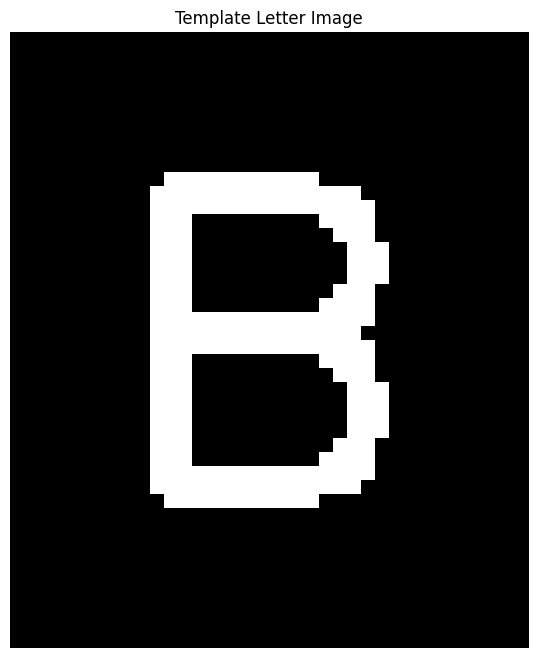

In [4]:
letter = letter_draw('B', 50)
show_image(letter, title='Template Letter Image')


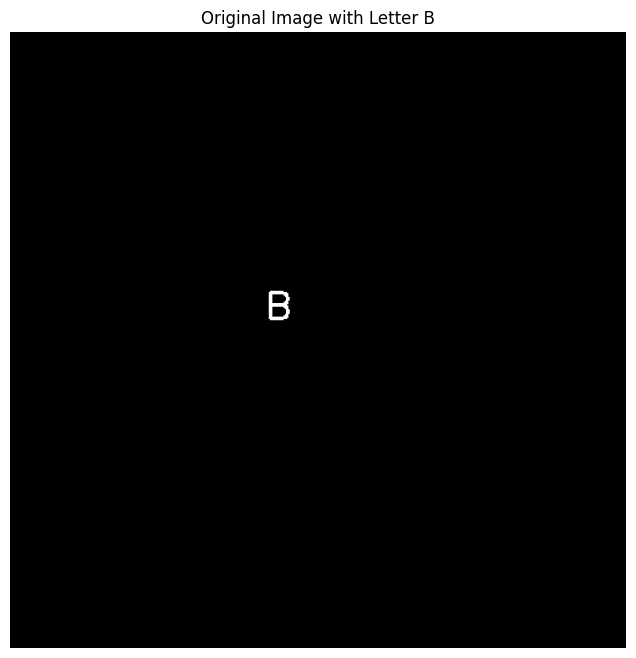

In [5]:
np_img = np.zeros((500, 500), dtype=np.uint8)


np_img[200:200+letter.shape[0], 200:200+letter.shape[1]]=letter


show_image(np_img, title='Original Image with Letter B')

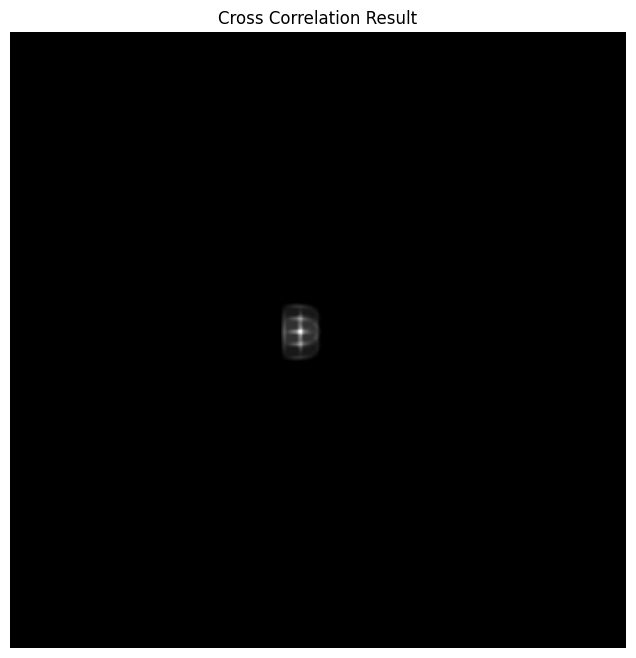

In [6]:
result = cross_correlation_on_fourier_domain(np_img, letter)

show_image(result, title='Cross Correlation Result')

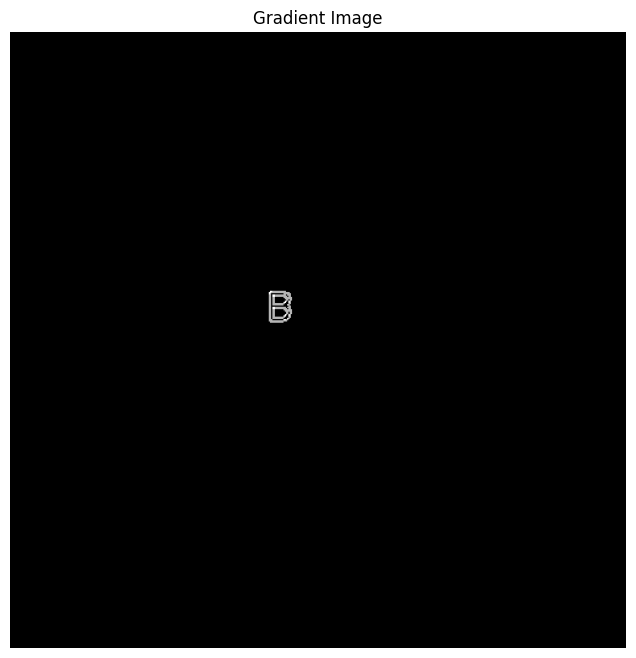

In [7]:
gradient_img = gradient(np_img)

show_image(gradient_img, title='Gradient Image')


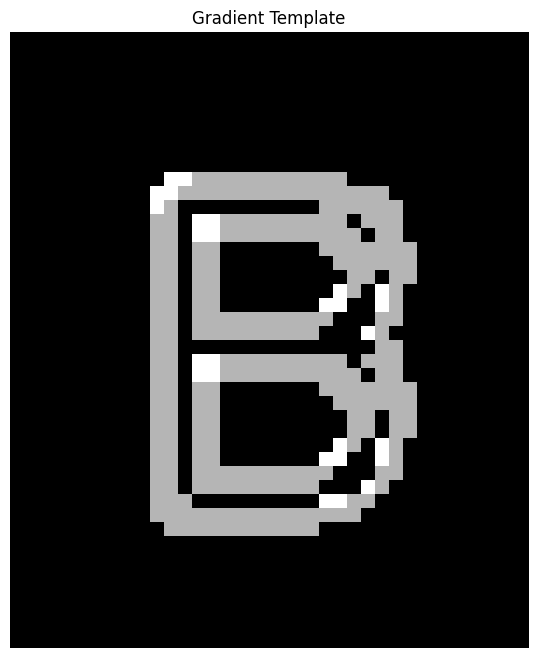

In [8]:
gradient_template = gradient(letter)

show_image(gradient_template, title='Gradient Template')

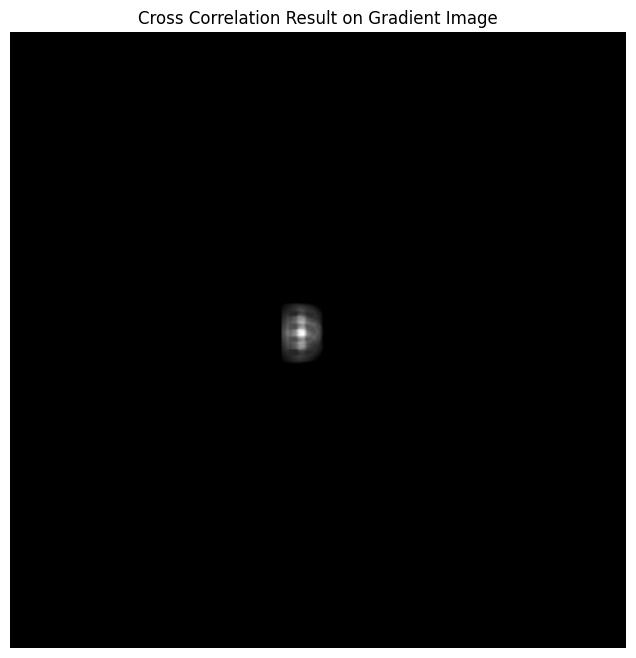

Cross Correlation Time:  11.626720428466797 ms


In [9]:
import time 
t1 = time.time()
result = cross_correlation_on_fourier_domain(np_img, gradient_template)

t2 = time.time()

show_image(result, title='Cross Correlation Result on Gradient Image')
ms_elapsed = (t2-t1)*1000
print("Cross Correlation Time: ", ms_elapsed, "ms")

NCC Time:  7967.920541763306 ms


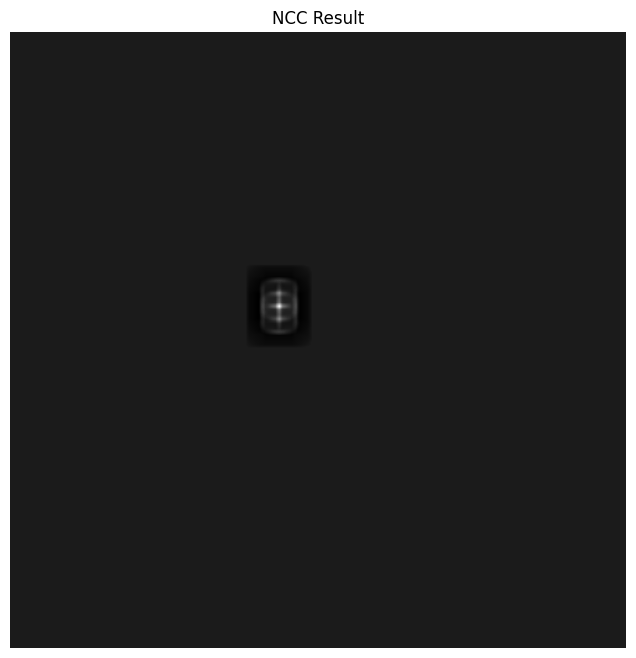

In [10]:
t1 = time.time()
ncc_map = ncc_on_image(np_img, letter)
t2 = time.time()

ms_elapsed = (t2-t1)*1000

print("NCC Time: ", ms_elapsed, "ms")

show_image(ncc_map, title='NCC Result')


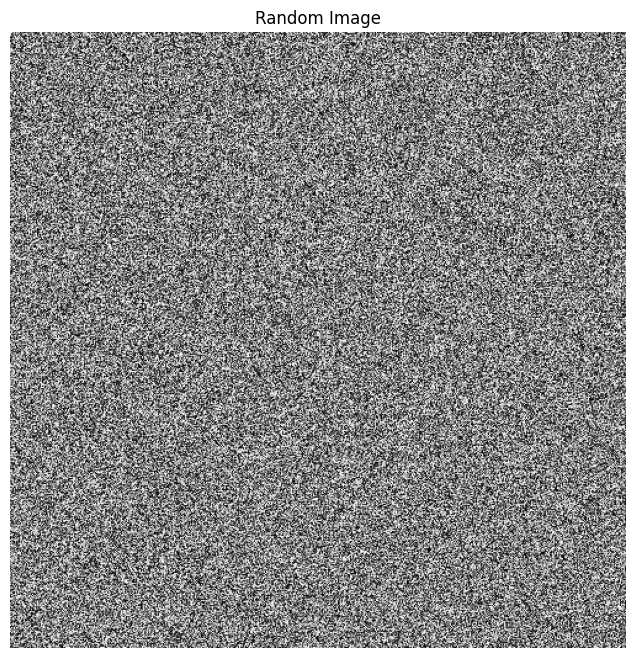

In [11]:
np_random_img = np.random.randint(0, 255, (500, 500), dtype=np.uint8)

show_image(np_random_img, title='Random Image')

[376]


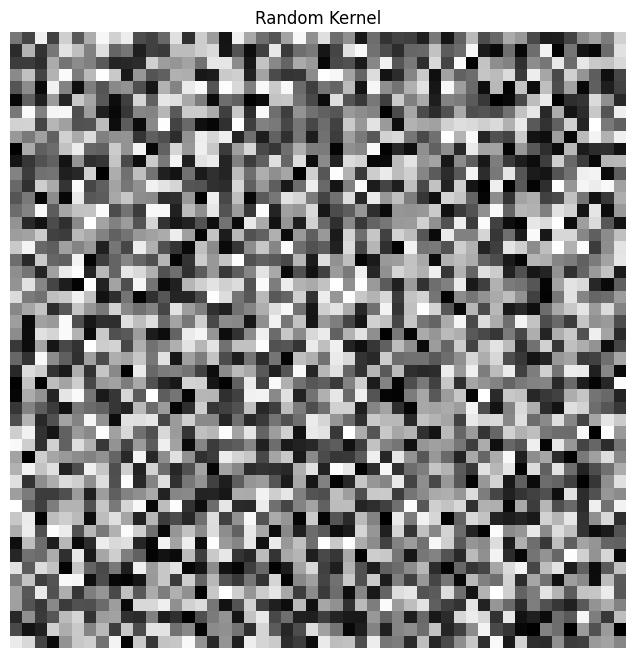

In [12]:
kernel_size = 50

random_start_point = np.random.randint(0, 500 - kernel_size, 1)
print(random_start_point)


random_kernel = np_random_img[random_start_point[0]:random_start_point[0]+kernel_size, random_start_point[0]:random_start_point[0]+kernel_size]

show_image(random_kernel, title='Random Kernel')



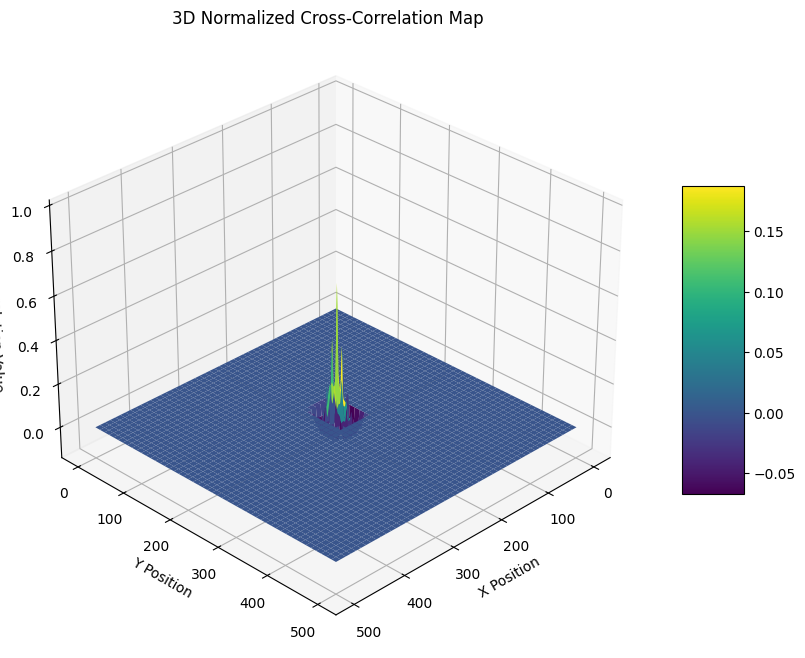

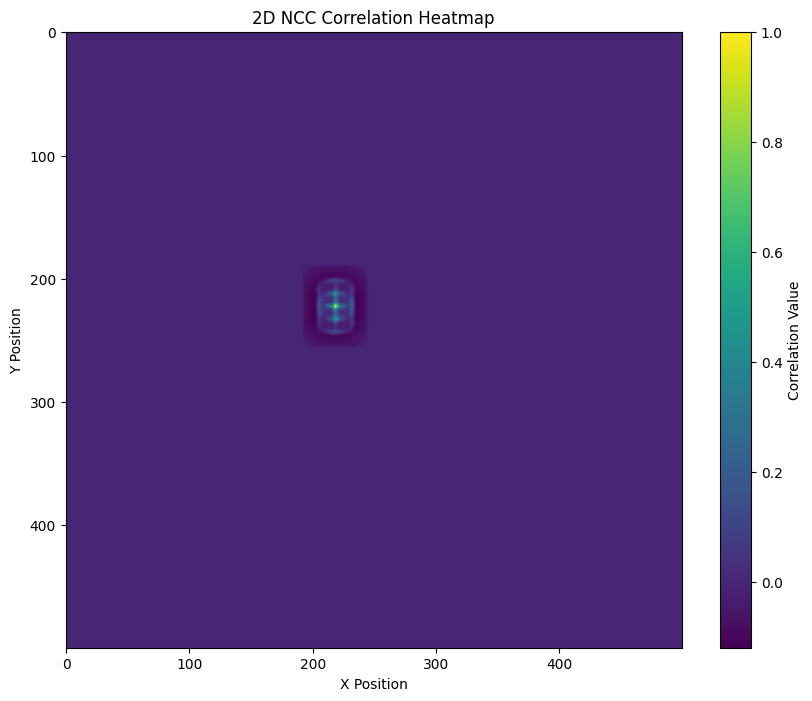

In [13]:
template_match = cross_correlation_on_fourier_domain(np_random_img, random_kernel)

plot_ncc_3d(ncc_map)

In [14]:
notebook_dir = os.path.abspath("")

images_dir = os.path.join(os.path.abspath(os.path.join(notebook_dir,"data", "test_images")))

print(images_dir)

list_images = os.listdir(images_dir)
i = 0
for image_name in list_images:
    print(f"image {i}: {image_name}\n")
    i += 1

/home/yasin/Projects/computer-vision-analysis/data/test_images
image 0: tree.bmp

image 1: palm.bmp

image 2: pale_blue_dot.tif

image 3: pepper.bmp

image 4: BoatsColor.bmp

image 5: boats.bmp

image 6: fbtaraftar.bmp

image 7: airplane.bmp

image 8: goldhill.bmp

image 9: baboon.bmp

image 10: landscape.bmp

image 11: barbara.bmp

image 12: lenna.bmp

image 13: low_contrast_lenna.bmp



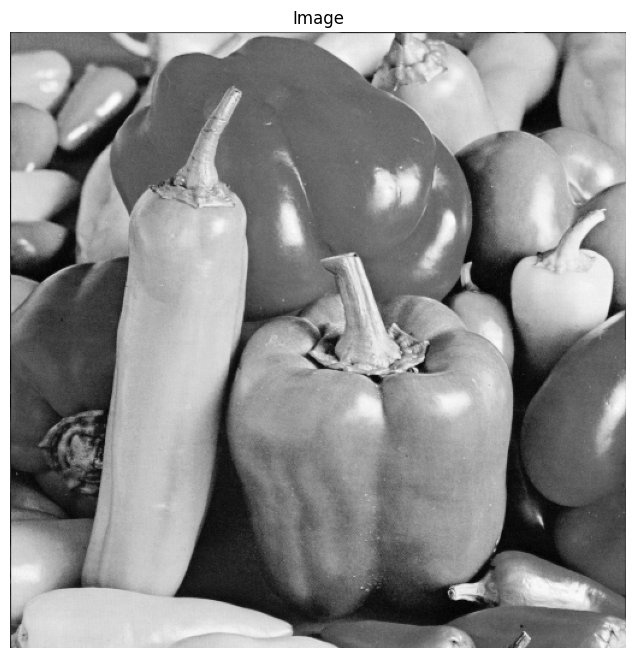

In [15]:
image = Image.open(os.path.join(images_dir, list_images[3]))
image = image.convert('L')
image = np.array(image)
img_width, img_height = image.shape

show_image(image, title='Image')

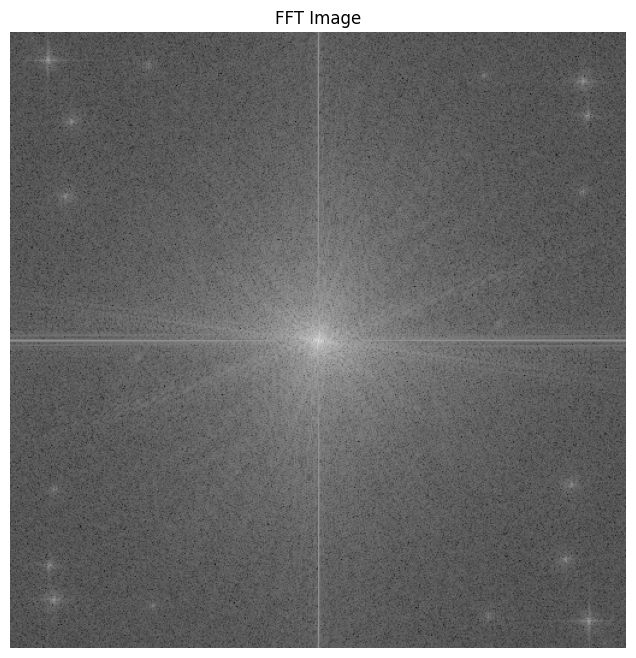

In [16]:
fft_image = np.fft.fft2(image)
fft_image = np.fft.fftshift(fft_image)
fft_image = np.abs(fft_image)


nlog_image = np.log(fft_image+1)

show_image(nlog_image, title='FFT Image')


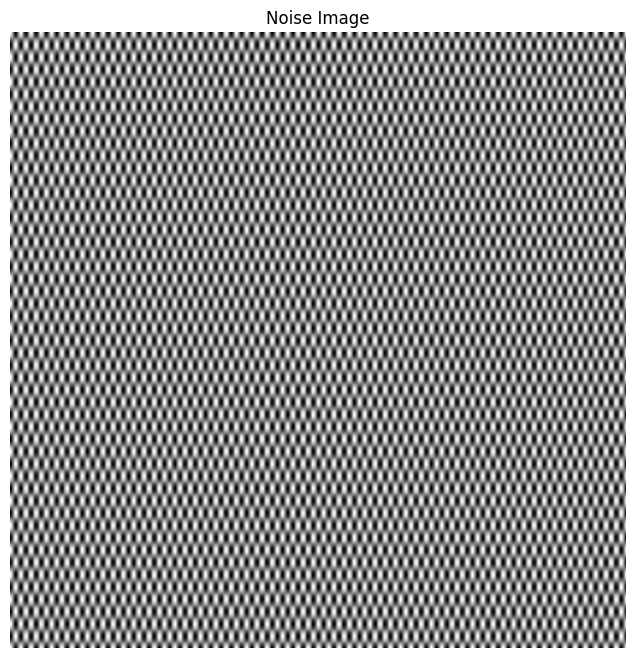

In [17]:


noise = noise_generator(img_width, img_height, 25,60, 20)


show_image(noise, title='Noise Image')


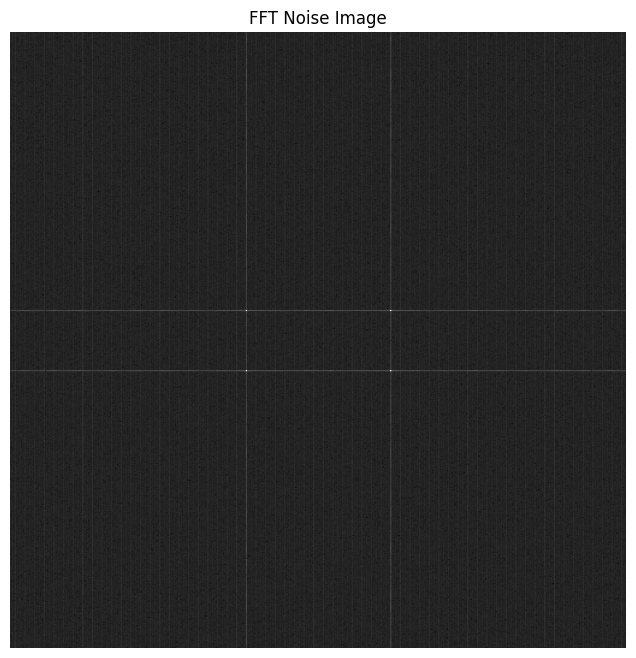

In [18]:
fft = np.fft.fft2(noise)
fft = np.fft.fftshift(fft)

fft_image = np.log(np.abs(fft))

show_image(fft_image, title='FFT Noise Image')


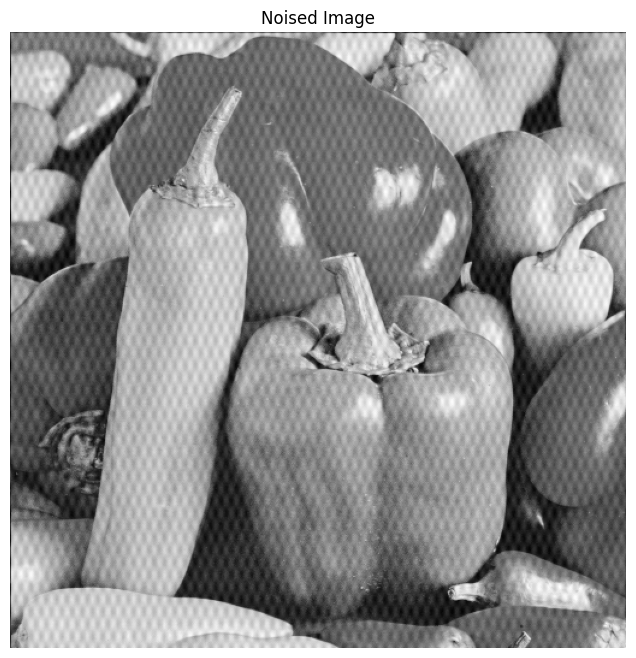

In [19]:
noised_image = image.astype(np.float32) + noise.astype(np.float32)

show_image(noised_image, title='Noised Image')


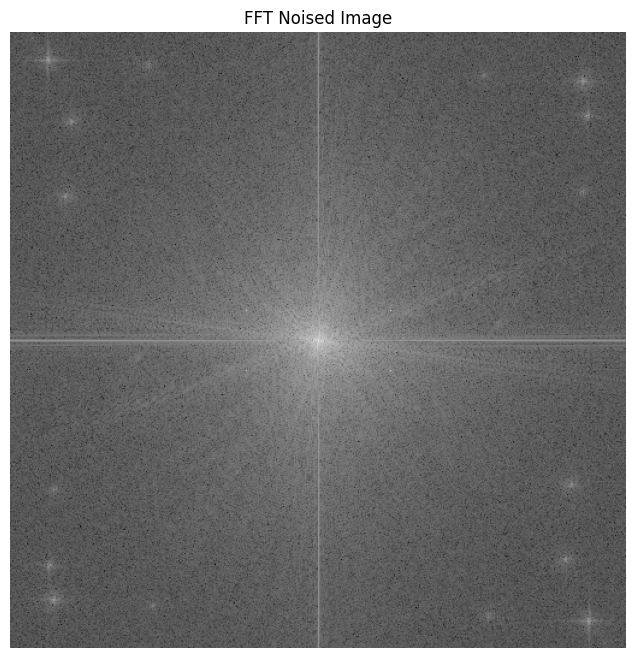

In [20]:
fft = np.fft.fft2(noised_image)
fft = np.fft.fftshift(fft)

fft_image = np.abs(fft)


np_log_image = np.log(fft_image)


show_image(np_log_image, title='FFT Noised Image')

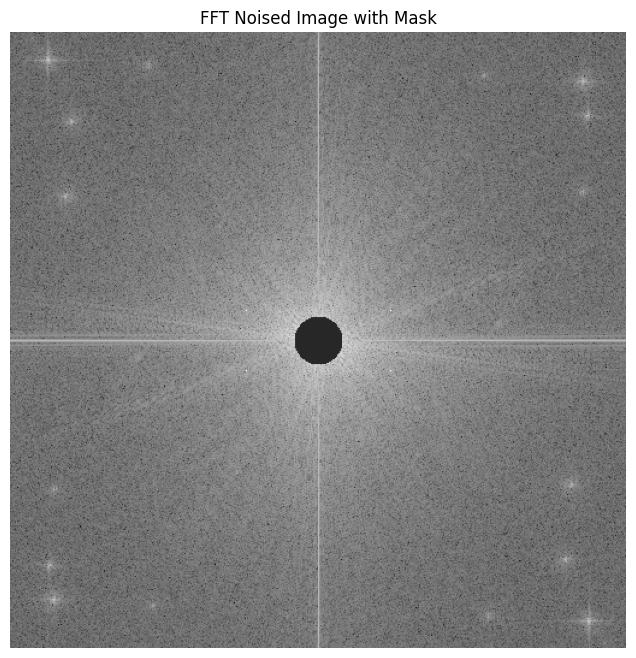

In [26]:
mean = np.mean(fft)
masked_fft = mask_radius(fft, 20, mean)

masked_fft_image = np.abs(masked_fft)


np_log_image = np.log(masked_fft_image)

show_image(np_log_image, title='FFT Noised Image with Mask')

In [27]:
min = np.min(masked_fft_image)
max = np.max(masked_fft_image)
print(f"Min: {min}, Max: {max}")


Min: 7.667658805847168, Max: 1318665.125


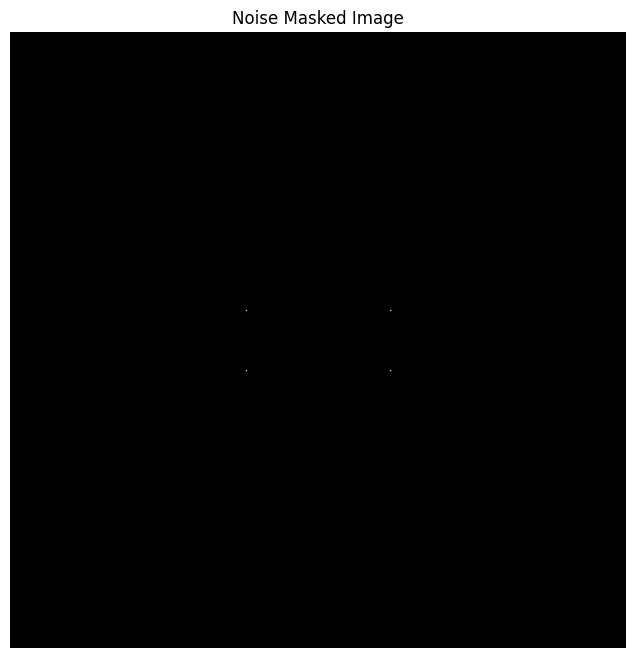

In [33]:
threshold = 0.5 * (min + max)

mask = masked_fft_image > threshold

show_image(mask, title='Noise Masked Image')

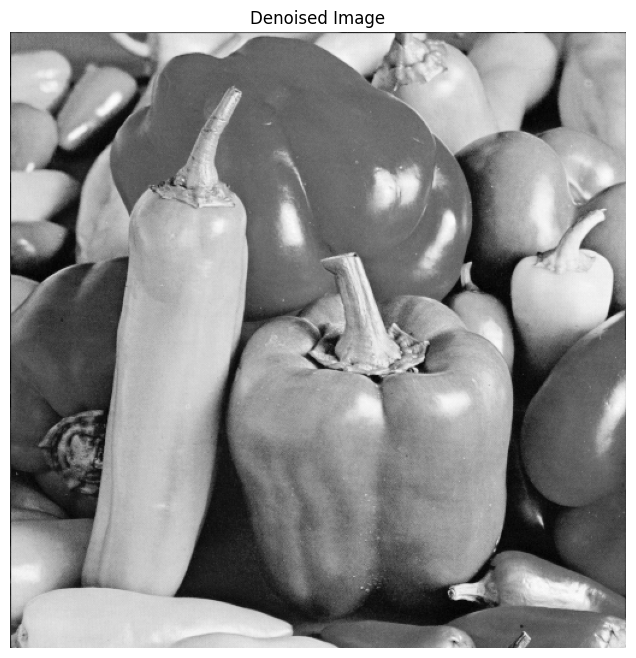

In [29]:
fft = np.fft.fft2(noised_image)
fft = np.fft.fftshift(fft)

fft_image = np.abs(fft)


denoised_fft = fft - fft * mask
denoised_image = np.fft.ifft2(np.fft.ifftshift(denoised_fft)).real

show_image(denoised_image, title='Denoised Image')

In [34]:
## psnr hesaplama

def psnr(image1, image2):
    mse = np.mean((image1 - image2)**2)
    max_pixel = 255.0
    return 20 * np.log10(max_pixel / np.sqrt(mse))

psnr_value = psnr(image, denoised_image)

print(f"PSNR: {psnr_value}")

PSNR: 73.4440689086914
